# Cursos de Series de tiempo con *Machine Learning*
## Modulo 53. Modelo de Pipeline
                        Elaborado por: Naren Castellon

El objetivo principal del siguiente artículo es obtener una guía paso a paso sobre cómo hacer un `Pipeline` con `Sklearn` para nuestro modelo de Serie Temporal usando `Mlforecast`.

Durante este tutorial, nos familiarizaremos con la clase principal `MlForecast` y algunos métodos relevantes como `mlforecast.fit`, `mlforecast.predict` y `mlforecast.cross_validation`, entre otros.

¡¡¡Empecemos!!!

<a class="anchor" id="0.1"></a>



1.	[Introduction](#1)
2.	[Loading libraries and Data](#3)
3.	[Explore Data with the plot method](#3)
4.	[Training A Multivariate Time Series Model With MLForecast](#4)
5.  [Feature importances](#5)
6.  [Evaluate the model’s performance](#6)
7.  [Evaluate the model](#7)
8.  [References](#8)

# **Introducción** <a class="anchor" id="1"></a>

[Table of Contents](#0)

Un `Pipeline` en el contexto de `Machine Learning` se refiere a una secuencia de pasos organizados de forma estructurada para procesar y transformar datos antes de entrenar un modelo y hacer predicciones. 

### **El `objetivo` principal de un pipeline es automatizar y estandarizar el flujo de trabajo, lo que facilita la reproducibilidad y la implementación de modelos en producción.**

Un proceso típico de aprendizaje automático consta de las siguientes etapas:

1. **Preprocesamiento de datos**: En esta etapa, se realizan varias tareas para preparar los datos antes de entrenar el modelo. Esto puede incluir limpieza de datos, manejo de valores faltantes, normalización o estandarización de variables, codificación de variables categóricas, selección de características relevantes, entre otros.

2. **División de datos**: es común dividir los datos en conjuntos de entrenamiento, validación y prueba. El conjunto de entrenamiento se usa para entrenar el modelo, el conjunto de validación se usa para ajustar los hiperparámetros y evaluar el rendimiento durante el ajuste del modelo, y el conjunto de prueba se usa para evaluar el rendimiento final del modelo.

3. **Entrenamiento de modelos**: en esta etapa, el modelo de aprendizaje automático se selecciona y se entrena utilizando los datos de entrenamiento. Esto implica ajustar los parámetros del modelo en función de los datos de entrenamiento para minimizar la función de pérdida o maximizar la métrica de rendimiento objetivo.

4. **Validación del modelo**: después de entrenar el modelo, su rendimiento se evalúa utilizando los datos de validación. Esto permite ajustar los hiperparámetros del modelo y realizar comparaciones entre diferentes configuraciones o algoritmos.

5. **Evaluación del modelo**: una vez que se han ajustado los hiperparámetros y se ha seleccionado el mejor modelo, se evalúa su rendimiento final utilizando el conjunto de prueba. Esto proporciona una estimación imparcial del rendimiento del modelo en datos invisibles.

6. **Predicciones**: Finalmente, el modelo entrenado se utiliza para realizar predicciones sobre datos nuevos o datos en tiempo real.

El uso de un `Pipeline` en el aprendizaje automático tiene varios beneficios como:

- La automatización de tareas repetitivas 
- La estandarización del flujo de trabajo
- La facilidad de reproducir resultados
- La capacidad de escalar y aplicar el modelo en producción de manera eficiente.

Es importante tener en cuenta que los pasos específicos y el orden de un `Pipeline` pueden variar según el problema y los requisitos del proyecto. Además, se pueden incluir etapas adicionales, como seleccionar el mejor modelo u optimizar hiperparámetros.

<center><img src="./imagen/pipeline%20regressor%20for%20time%20series.png" width="800" height="500"></center>

# **Loading libraries and Data** <a class="anchor" id="2"></a>

[Table of Contents](#0)

In [110]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import datetime as dt
import time
from datetime import datetime, timedelta

# 
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose 

In [111]:
# Models Sklearn
# ==============================================================================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Mlforecast
# ==============================================================================
from mlforecast import MLForecast
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean
from mlforecast.target_transforms import Differences

from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series
from utilsforecast.preprocessing import fill_gaps

In [112]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5

# Define the plot size
# ==============================================================================

plt.rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

## **Read data**

Utilizaremos datos del [conjunto de datos de tráfico del sitio web de la ciudad de Los Ángeles](https://www.kaggle.com/datasets/cityofLA/lacity.org-website-traffic) en Kaggle.

Este conjunto de datos contiene el número de sesiones de usuarios del sitio web de la ciudad de Los Ángeles para cada día de 2014 a 2019.

Las sesiones son períodos de tiempo en los que un usuario está activo en un sitio web.

In [113]:
df=pd.read_csv("./data/lacity.org-website-traffic.csv", ) #.loc[:, ['Date', 'Device Category', 'Sessions']]
df.head()

,Date,Device Category,Browser,# of Visitors,Sessions,Bounce Rate
0,2014-01-01T00:00:00.000,desktop,Chrome,900,934,55.5675
1,2014-01-01T00:00:00.000,desktop,Firefox,692,761,40.8673
2,2014-01-01T00:00:00.000,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01T00:00:00.000,desktop,Opera,35,35,100.0000
4,2014-01-01T00:00:00.000,desktop,Safari,484,554,24.9097


In [114]:
df.columns = [k.lower().replace(' ', '_').replace('#', 'qnty') for k in df.columns]
df['date'] = pd.to_datetime(df.date).dt.normalize()
df

,date,device_category,browser,qnty_of_visitors,sessions,bounce_rate
0,2014-01-01,desktop,Chrome,900,934,55.5675
1,2014-01-01,desktop,Firefox,692,761,40.8673
2,2014-01-01,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01,desktop,Opera,35,35,100.0000
4,2014-01-01,desktop,Safari,484,554,24.9097
...,...,...,...,...,...,...
8348980,2019-08-27,mobile,Chrome,199,318,50.0000
8348981,2019-08-27,mobile,Firefox,40,40,100.0000
8348982,2019-08-27,mobile,Safari,199,199,79.8995
8348983,2019-08-27,tablet,Amazon Silk,40,40,100.0000


In [115]:
df[df["device_category"] == "desktop"]

,date,device_category,browser,qnty_of_visitors,sessions,bounce_rate
0,2014-01-01,desktop,Chrome,900,934,55.5675
1,2014-01-01,desktop,Firefox,692,761,40.8673
2,2014-01-01,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01,desktop,Opera,35,35,100.0000
4,2014-01-01,desktop,Safari,484,554,24.9097
...,...,...,...,...,...,...
8348967,2019-08-26,desktop,Safari,398,437,27.2311
8348976,2019-08-27,desktop,Chrome,278,318,50.0000
8348977,2019-08-27,desktop,Edge,40,40,0.0000
8348978,2019-08-27,desktop,Firefox,40,40,0.0000


In [116]:
df[df["device_category"] == "tablet"]

,date,device_category,browser,qnty_of_visitors,sessions,bounce_rate
10,2014-01-01,tablet,Amazon Silk,35,35,100.0000
11,2014-01-01,tablet,Android Browser,35,35,100.0000
12,2014-01-01,tablet,Safari,208,242,28.5124
24,2014-01-02,tablet,Android Browser,35,35,100.0000
25,2014-01-02,tablet,Chrome,173,208,50.0000
...,...,...,...,...,...,...
8348960,2019-08-25,tablet,Safari,119,119,33.6134
8348974,2019-08-26,tablet,Internet Explorer,40,40,0.0000
8348975,2019-08-26,tablet,Safari,119,119,33.6134
8348983,2019-08-27,tablet,Amazon Silk,40,40,100.0000


In [ ]:
#df.drop_duplicates(inplace=True)

In [117]:
# Aggregate the data based on Date, Device and Session.
data = df[['date', 'device_category', 'sessions', "qnty_of_visitors","bounce_rate"]].groupby(['date', 'device_category']).sum().reset_index()

# Fill Missing Any Date to 0
df_pivot = data.pivot(index='device_category', values=['sessions',"qnty_of_visitors","bounce_rate"], columns='date')
df_pivot.fillna(0, inplace=True)

df_pivot = df_pivot.stack().reset_index().sort_values(by=['date', 'device_category']).reset_index(drop=True)
df_pivot.columns = ['device', 'date', 'session', "qnty_of_visitors","bounce_rate"]
data = df_pivot[['date', 'device', 'session', "qnty_of_visitors","bounce_rate"]]

del df_pivot

In [118]:
data.head()

,date,device,session,qnty_of_visitors,bounce_rate
0,2014-01-01,desktop,1032805.0,951965.0,80409.6292
1,2014-01-01,mobile,537573.0,491391.0,127525.9261
2,2014-01-01,tablet,92474.0,80929.0,40155.9092
3,2014-01-02,desktop,2359710.0,2124343.0,57484.0156
4,2014-01-02,mobile,607544.0,491822.0,100647.0807


The input to MlForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [119]:
data=data.rename(columns={"date": "ds","device":"unique_id", "session": "y"})
data.head()

,ds,unique_id,y,qnty_of_visitors,bounce_rate
0,2014-01-01,desktop,1032805.0,951965.0,80409.6292
1,2014-01-01,mobile,537573.0,491391.0,127525.9261
2,2014-01-01,tablet,92474.0,80929.0,40155.9092
3,2014-01-02,desktop,2359710.0,2124343.0,57484.0156
4,2014-01-02,mobile,607544.0,491822.0,100647.0807


# **Explore Data with the plot method** <a class="anchor" id="3"></a>

[Table of Contents](#0)

We are going to use the `plot_series` function to visualize our data.

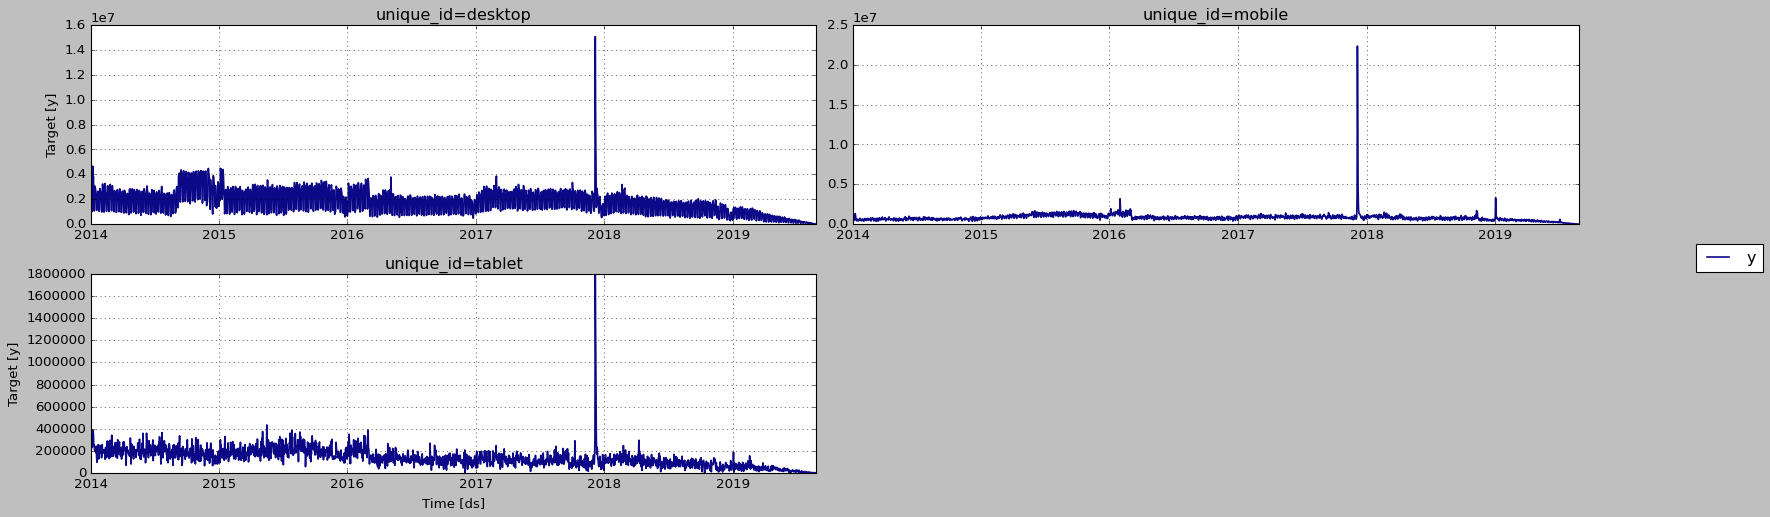

In [120]:
plot_series(data, palette="plasma", engine="matplotlib")
#fig.savefig('../figs/pipeline_with_sklearn_and_xgboost_random_forest__eda.png')


## **The Augmented Dickey-Fuller Test**

Una prueba de Dickey-Fuller aumentada (ADF) es un tipo de prueba estadística que determina si una raíz unitaria está presente en los datos de series de tiempo. Las raíces unitarias pueden provocar resultados impredecibles en el análisis de series temporales. Se forma una hipótesis nula en la prueba de raíz unitaria para determinar en qué medida una tendencia afecta los datos de series de tiempo. Al aceptar la hipótesis nula, aceptamos la evidencia de que los datos de la serie temporal no son estacionarios. Al rechazar la hipótesis nula o aceptar la hipótesis alternativa, aceptamos la evidencia de que los datos de la serie temporal se generan mediante un proceso estacionario. Este proceso también se conoce como tendencia estacionaria. Los valores del estadístico de prueba ADF son negativos. Los valores más bajos de ADF indican un rechazo más fuerte de la hipótesis nula.

La prueba Dickey-Fuller aumentada es una prueba estadística común que se utiliza para comprobar si una serie de tiempo determinada es estacionaria o no. Podemos lograr esto definiendo la hipótesis nula y alternativa.

- Hipótesis nula: la serie temporal no es estacionaria. Da una tendencia dependiente del tiempo.
- Hipótesis alternativa: la serie temporal es estacionaria. En otras palabras, la serie no depende del tiempo.

- Estadístico ADF o t < valores críticos: Rechaza la hipótesis nula, la serie temporal es estacionaria.
- Estadística ADF o t > valores críticos: No se pudo rechazar la hipótesis nula, la serie temporal no es estacionaria.

In [121]:
#results = data.groupby('unique_id').apply(lambda group: adfuller(group['y'], autolag='AIC'))

In [122]:
# Crear una lista de los valores críticos


# Imprimir los resultados
for unique_id, result in results.items():
    print(f"unique_id: {unique_id}")
    #print(f"ADF Statistic: {result[0]}")
    #print(f"p-value: {result[1]}")
    #print(f"Critical Values: {result[4]}")
    #critical_values.append(result[4])
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in result[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    if result[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")
    print("---------------------------------------")

unique_id: desktop
Test Statistic                   -1.333370
p-value                           0.613770
No Lags Used                     26.000000
Number of observations used    2038.000000
Critical Value (1%)              -3.433563
Critical Value (5%)              -2.862959
Critical Value (10%)             -2.567526
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary
---------------------------------------
unique_id: mobile
Test Statistic                -7.373573e+00
p-value                        8.841476e-11
No Lags Used                   1.300000e+01
Number of observations used    2.051000e+03
Critical Value (1%)           -3.433542e+00
Critical Value (5%)           -2.862950e+00
Critical Value (10%)          -2.567521e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary
---------------------------------------
unique_id: tablet
Test Statistic                   -2.760312
p-value                          

# **Split the data into training and testing** 


Dividamos nuestros datos en dos partes:

1. Datos para entrenar el modelo.
2. Datos para probar el modelo, aquí usaremos los últimos 30 días.

In [123]:
ohe = fill_gaps(
    data,
    freq='D')

ohe

,unique_id,ds,y,qnty_of_visitors,bounce_rate
0,desktop,2014-01-01,1032805.0,951965.0,80409.6292
1,desktop,2014-01-02,2359710.0,2124343.0,57484.0156
2,desktop,2014-01-03,2033439.0,1883349.0,96106.1499
3,desktop,2014-01-04,975623.0,938501.0,64826.1249
4,desktop,2014-01-05,1237064.0,1121593.0,53496.3468
...,...,...,...,...,...
6190,tablet,2019-08-23,797.0,797.0,400.0000
6191,tablet,2019-08-24,717.0,597.0,119.5980
6192,tablet,2019-08-25,398.0,398.0,267.2268
6193,tablet,2019-08-26,199.0,199.0,133.6134


In [124]:
ohe.isnull().sum()

unique_id           0
ds                  0
y                   0
qnty_of_visitors    0
bounce_rate         0
dtype: int64

In [ ]:
#data[data["unique_id"] == "mobile"].tail(31)

In [125]:
train = data[data.ds<='2019-07-28'] 
test=data[(data['ds'] > '2019-07-28')]

test.drop("y",axis=1, inplace=True)
train.shape, test.shape

((6105, 5), (90, 4))

In [ ]:
test[test["unique_id"] == "tablet"].tail(31).shape

# **Training A Multivariate Model With MLForecast**<a class="anchor" id="4"></a>

[Table of Contents](#0)

## **Building Model**

Veamos cómo podemos diseñar funciones y entrenar un "XGBoost" y un "RandomForest" con mlforecast.

En este caso vamos a crear un `Pipeline` con la función `make_pileline` en el cual vamos a usar el `SimpleImputer` en caso de que tengamos datos nulos, y también usaremos el `StandardScaler` para la estandarización del datos. Recordemos que el `StandarScaler` y el `SimpleImputer` se ejecutan en el método fit.

Hemos agregado la función `StandardScaler` a la construcción del modelo que vamos a usar, sin embargo podemos crear esta misma función y usarla en el parámetro `differences`, sin embargo para ejemplificar este tutorial vamos a utilice el `StandardScaler` de la construcción del `Pipeline`.

In [126]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from mlforecast.target_transforms import LocalRobustScaler, LocalStandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [127]:
num_selector = make_column_selector(dtype_include=np.number)
num_selector

In [128]:
num_linear_processor = make_pipeline(StandardScaler(),
                                     PowerTransformer(method = 'yeo-johnson'),
                                     SimpleImputer(strategy="mean", add_indicator=True))
num_linear_processor

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('simpleimputer', SimpleImputer(add_indicator=True))])

In [129]:
linear_preprocessor = make_column_transformer((num_linear_processor, num_selector))
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('powertransformer',
                                                  PowerTransformer()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])

In [130]:
rf_pipe = make_pipeline(linear_preprocessor, RandomForestRegressor())
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [131]:
xgb_pipe = make_pipeline(linear_preprocessor, XGBRegressor())
xgb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])),
                ('xgbregressor',
                 XGBRegressor(base_score=N...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [132]:
#models = [XGBRegressor(random_state = 1463, n_estimators = 1000, max_depth = 5), rf_pipe]
models = [rf_pipe, xgb_pipe]
models

[Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline',
                                                   Pipeline(steps=[('standardscaler',
                                                                    StandardScaler()),
                                                                   ('powertransformer',
                                                                    PowerTransformer()),
                                                                   ('simpleimputer',
                                                                    SimpleImputer(add_indicator=True))]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])),
                 ('randomforestregressor', RandomForestRegressor())]),
 Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline',
                                               

### Opción 2

In [133]:
models_2 = [make_pipeline(SimpleImputer(strategy="mean", add_indicator=True), 
                        StandardScaler(),
                        PowerTransformer(method='yeo-johnson'),
                        RandomForestRegressor(random_state=0, n_estimators=100)),
                        
                        XGBRegressor(random_state=0, n_estimators=100)]
models_2

[Pipeline(steps=[('simpleimputer', SimpleImputer(add_indicator=True)),
                 ('standardscaler', StandardScaler()),
                 ('powertransformer', PowerTransformer()),
                 ('randomforestregressor',
                  RandomForestRegressor(random_state=0))]),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num

We fit the models by instantiating a new `MlForecast` object with the following parameters:

* `models:` a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `lags:` Lags of the target to uses as feature.

* `lag_transforms:` Mapping of target lags to their transformations.

* `date_features:` Features computed from the dates. Can be `pandas` date attributes or functions that will take the dates as input.

* `differences:` Differences to take of the target before computing the features. These are restored at the forecasting step.

* `num_threads:` Number of threads to use when computing the features.

* `target_transforms:` Transformations that will be applied to the target computing the features and restored after the forecasting step.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

El argumento "retrasos" es una lista de retrasos que queremos utilizar en nuestro modelo. Los retrasos son la cantidad de pasos en el pasado que queremos usar para predecir el futuro.

Entonces, en nuestro caso, estamos usando el valor de la variable objetivo 1, 7 y 14 días antes de la fecha de la observación.

Por eso es importante tener todas las fechas, incluso aquellas con valores faltantes y ceros en los conjuntos de datos, para que estas características se puedan calcular correctamente.

También pasamos el argumento `lag_transforms`, que es un diccionario con `lag` como clave y una lista de funciones como valor.

Estas funciones se aplicarán a las series rezagadas. Por ejemplo, estamos aplicando una "media móvil" con una ventana de 7 días al retraso 1.

Esto significa que tendremos una característica que es la media de los 7 últimos valores de la variable objetivo después de cambiarla 1 día.

Estamos utilizando la biblioteca `window_ops` que está optimizada y recomendada para MLForecast.

Cada tupla en la lista de transformaciones es una función y sus argumentos. Por ejemplo, la función `rolling_mean` toma el tamaño de una ventana como argumento.

El mejor valor para el tamaño de la ventana es específico para cada serie temporal, por lo que debemos probar diferentes valores y ver cuál funciona mejor.

El argumento `date_features` es una lista de componentes de fecha que queremos extraer de la columna de fecha.

In [134]:
mlf = MLForecast(models = models,
                   freq='D',
                   lags=range(1,14, 1),
                   #lag_transforms={   1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)], 1: [expanding_mean]},
                   #target_transforms=[Differences([1])], # LocalRobustScaler(scale='iqr')  Differences([1]), LocalStandardScaler ()
                   date_features=['week', 'month','day', 'dayofweek'],
                   num_threads=6)

With the `preprocess` function we can observe all the transformation that has been made of the target variable before training the model.

In [ ]:
prep = mlf.preprocess(train)
prep.head()

In [ ]:
plot_series(prep)
#fig.savefig('../figs/pipeline_with_sklearn_and_xgboost_random_forest__prep.png')

In [ ]:
prep.drop(columns=['unique_id', 'ds']).corr()['y']

Aquí podemos observar la relación que existe entre cada día de una de las variables, con esta información podemos usarla para tomar una decisión sobre qué proceso (lags o lag_transforms) podemos usar, al final del entrenamiento y predicciones del modelo vamos a visualizar las características más cantidades, tendremos un poco más de base para poder agregar o eliminar aquellas transformaciones que serán de mayor importancia para nuestro modelo.

## **Fit method**

In [135]:
# fit the models
mlf.fit(train,fitted=True, 
        prediction_intervals=PredictionIntervals(n_windows=3, h=30, method="conformal_distribution") )

MLForecast(models=[RandomForestRegressor, XGBRegressor], freq=D, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13'], date_features=['week', 'month', 'day', 'dayofweek'], num_threads=6)

## **Predict method with prediction intervals**

In [136]:
forecast_df = mlf.predict(h = 30,level=[80,95],)
forecast_df 

,unique_id,ds,RandomForestRegressor,XGBRegressor,RandomForestRegressor-lo-95,RandomForestRegressor-lo-80,RandomForestRegressor-hi-80,RandomForestRegressor-hi-95,XGBRegressor-lo-95,XGBRegressor-lo-80,XGBRegressor-hi-80,XGBRegressor-hi-95
0,desktop,2019-07-29,164190.94,157718.625000,117595.06875,124398.975,203982.905,210786.81125,119049.296875,132922.000000,182515.250000,196387.953125
1,desktop,2019-07-30,159503.41,150781.343750,102495.72000,120508.140,198498.680,216511.10000,112182.863281,117062.421875,184500.265625,189379.824219
2,desktop,2019-07-31,156350.28,151560.906250,127691.50250,131059.700,181640.860,185009.05750,123277.951172,127058.273438,176063.539062,179843.861328
3,desktop,2019-08-01,124335.91,131684.890625,102114.21250,104153.080,144518.740,146557.60750,115887.173828,119701.164062,143668.617188,147482.607422
4,desktop,2019-08-02,120900.77,126237.218750,97590.47625,100792.365,141009.175,144211.06375,92322.968750,95047.343750,157427.093750,160151.468750
...,...,...,...,...,...,...,...,...,...,...,...,...
85,tablet,2019-08-23,2629.67,7016.456055,835.76875,969.235,4290.105,4423.57125,-895.853271,-220.568359,14253.480469,14928.765381
86,tablet,2019-08-24,2493.13,5670.213867,-5397.39250,-3546.640,8532.900,10383.65250,-8545.133789,-7540.110352,18880.538086,19885.561523
87,tablet,2019-08-25,2533.03,5670.213867,-3434.20875,-1811.565,6877.625,8500.26875,-3877.891357,-3600.712891,14941.140625,15218.319092
88,tablet,2019-08-26,2595.75,7731.333496,1188.23875,1522.795,3668.705,4003.26125,-7625.246094,-6447.551270,21910.218262,23087.913086


We can see the predictions for the Pipeline (Random Forest) and the XGBRegressor models.

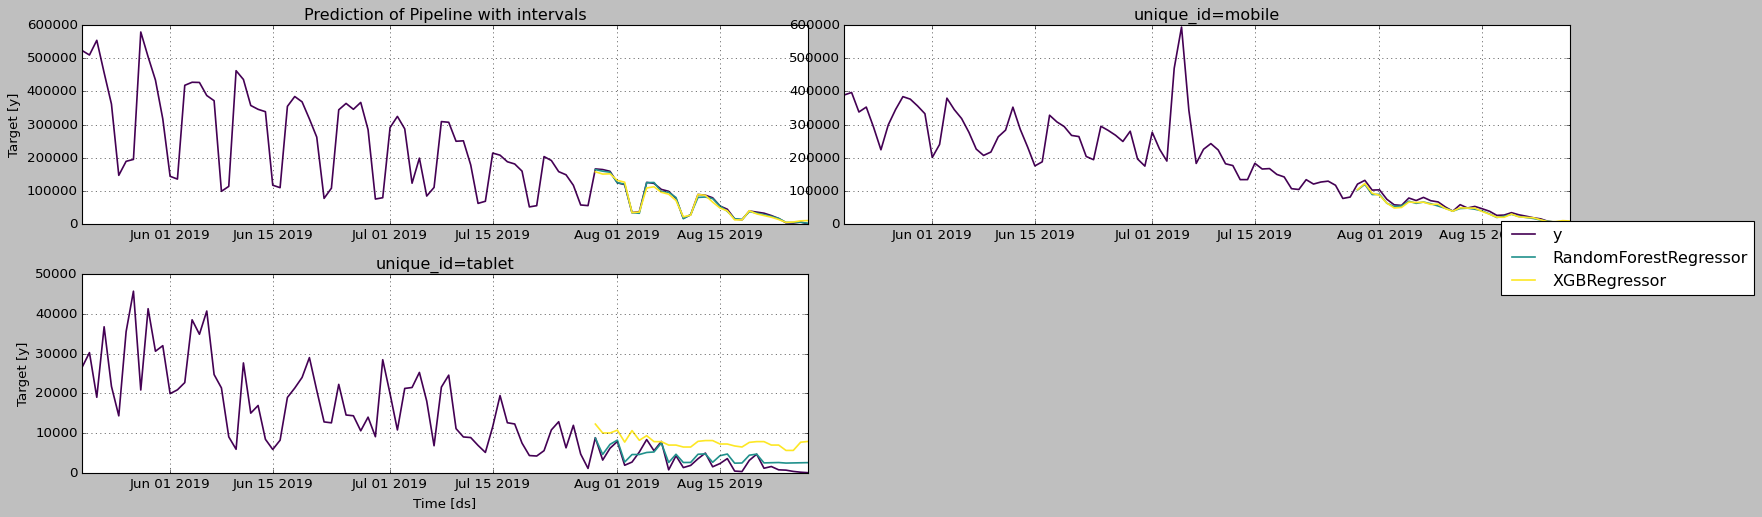

In [137]:
fig= plot_series(data, forecast_df,  max_insample_length=100,engine="matplotlib")
fig.get_axes()[0].set_title("Prediction of Pipeline with intervals")
#fig.savefig('../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_forecasting_pipeline_intervals.png')
fig

![](../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_forecasting_pipeline_intervals.png)

# **Feature importances**

In [ ]:
fig=pd.Series(mlf.models_['XGBRegressor'].feature_importances_, 
          index=mlf.ts.features_order_).sort_values(ascending=False).plot.bar(title='Feature Importance XGBRegressor')
plt.grid(True)
#plt.savefig('../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_feature_importance.png',dpi=300)
#plt.close()

![](../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_feature_importance.png)

# **Evaluate the model’s performance** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

## **Perform time series cross-validation**

Para obtener una estimación de qué tan bien será nuestro modelo al predecir datos futuros, podemos realizar una validación cruzada, que consiste en entrenar algunos modelos de forma independiente en diferentes subconjuntos de datos, usarlos para predecir un conjunto de validación y medir su desempeño.

Dado que nuestros datos dependen del tiempo, hacemos nuestras divisiones eliminando las últimas partes de la serie y usándolas como conjuntos de validación. Este proceso se implementa en `MLForecast.cross_validation`.

La validación cruzada de modelos de series temporales se considera una mejor práctica, pero la mayoría de las implementaciones son muy lentas. La biblioteca `MlForecast` implementa la validación cruzada como una operación distribuida, lo que hace que el proceso requiera menos tiempo. Si tiene grandes conjuntos de datos, también puede realizar una validación cruzada en un clúster distribuido usando "Ray, Dask o Spark".

Dependiendo de su computadora, este paso debería tomar alrededor de 1 minuto.

El método cross_validation de la clase StatsForecast toma los siguientes argumentos.

* `df:` marco de datos de entrenamiento

* `h (int):` representa h pasos hacia el futuro que se están pronosticando. En este caso, con 12 meses de antelación.

* `step_size (int):` tamaño de paso entre cada ventana. En otras palabras: con qué frecuencia desea ejecutar los procesos de previsión.

* `n_windows(int):` número de ventanas utilizadas para la validación cruzada. En otras palabras: ¿cuántos procesos de previsión en el pasado desea evaluar?

In [ ]:
cv_result = mlf.cross_validation(
    train,
    n_windows=5,  # number of models to train/splits to perform
    h =30,  # length of the validation set in each window
    prediction_intervals=PredictionIntervals(n_windows=5, h =30, method="conformal_distribution")
)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` index. If you dont like working with index just run `crossvalidation_df.resetindex()`.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [138]:
cv_result

,unique_id,ds,cutoff,y,RandomForestRegressor,XGBRegressor
0,desktop,2019-03-01,2019-02-28,939607.0,1218596.14,1.192968e+06
1,desktop,2019-03-02,2019-02-28,440711.0,1216569.05,1.197161e+06
2,desktop,2019-03-03,2019-02-28,395436.0,1207517.14,1.210728e+06
3,desktop,2019-03-04,2019-02-28,1114400.0,1239184.58,1.250606e+06
4,desktop,2019-03-05,2019-02-28,1152647.0,1248607.22,1.235344e+06
...,...,...,...,...,...,...
445,tablet,2019-07-24,2019-06-28,12876.0,14707.83,1.591257e+04
446,tablet,2019-07-25,2019-06-28,6323.0,14577.61,1.439521e+04
447,tablet,2019-07-26,2019-06-28,11972.0,14379.81,1.439521e+04
448,tablet,2019-07-27,2019-06-28,4744.0,14384.08,1.328527e+04


# **Evaluate the model** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

`pip install datasetsforecast`

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case,`Pipeline` and `XGBRegressor() Model`.

In [139]:
from datasetsforecast.losses import mse, mae, rmse, mape

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [140]:
evaluation_df = evaluate_cross_validation(cv_result.set_index("unique_id"), rmse)

evaluation_df

,RandomForestRegressor,XGBRegressor,best_model
unique_id,,,
desktop,346896.220072,353961.469792,RandomForestRegressor
mobile,121003.546844,120512.310324,XGBRegressor
tablet,15672.769747,15635.375698,XGBRegressor


In [141]:
plot_series(data, forecast_df,  max_insample_length=100, engine = "plotly")

1. magma
2. cividis
3. inferno
4. plasma
5. viridis

In [ ]:
plt.style.use('classic')

fig = plot_series(data, forecast_df, level=[80,95], max_insample_length=100,engine="matplotlib", palette="plasma", models= ["XGBRegressor"])
fig

## Hyperparameter para XGBoost y Random Forest con Optuna

In [ ]:
test=data[(data['ds'] > '2019-07-28')]

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error
import optuna
def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'max_leaves': trial.suggest_int('max_leaves', 8, 1024),
        
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.01, 0.5),
        "random_state" : trial.suggest_categorical('random_state', [42]),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror']),
        "n_jobs" : trial.suggest_categorical('n_jobs', [-1]),
             }
    
    model_xgb = [XGBRegressor(**params)]

    mlf_xgb = MLForecast(models = model_xgb,
                   freq='D',
                   lags=range(1,14, 1),
                   #lag_transforms={   1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)], 1: [expanding_mean]},
                   #target_transforms=[Differences([1])], # LocalRobustScaler(scale='iqr')  Differences([1]), LocalStandardScaler ()
                   #date_features=['week', 'month','day', 'dayofweek'],
                   num_threads=6)


    mlf_xgb.fit(train,fitted=True, static_features= [],
    prediction_intervals=PredictionIntervals(n_windows=3, h=30, method="conformal_distribution") )
    

    y_pred = mlf_xgb.predict(h = 30,level=[80,95], X_df= test)

    y_pred = y_pred.merge(test[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

    error = mean_absolute_percentage_error(y_pred['y'], y_pred['XGBRegressor'])

    return error

In [ ]:
study_xgb = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)

In [142]:
print("Number of finished trials: {}".format(len(study_xgb.trials)))
print('Best trial:', study_xgb.best_trial.params)

Number of finished trials: 50
Best trial: {'booster': 'gbtree', 'max_depth': 9, 'max_leaves': 473, 'learning_rate': 0.0887841067168043, 'n_estimators': 1402, 'min_child_weight': 11, 'subsample': 0.8214328698985858, 'reg_alpha': 0.1349188006394201, 'reg_lambda': 0.9877689900035628, 'colsample_bylevel': 0.43387183443932886, 'colsample_bytree': 0.5975138027748159, 'colsample_bynode': 0.2098776654399035, 'random_state': 42, 'objective': 'reg:squarederror', 'n_jobs': -1}


In [143]:
best_params = study_xgb.best_trial.params
best_params

{'booster': 'gbtree',
 'max_depth': 9,
 'max_leaves': 473,
 'learning_rate': 0.0887841067168043,
 'n_estimators': 1402,
 'min_child_weight': 11,
 'subsample': 0.8214328698985858,
 'reg_alpha': 0.1349188006394201,
 'reg_lambda': 0.9877689900035628,
 'colsample_bylevel': 0.43387183443932886,
 'colsample_bytree': 0.5975138027748159,
 'colsample_bynode': 0.2098776654399035,
 'random_state': 42,
 'objective': 'reg:squarederror',
 'n_jobs': -1}

#### Random Fores Optuna

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error
import optuna

def objective_rf(trial):
    """Define the objective function"""

    params = {"n_estimators": trial.suggest_int("n_estimators", 100, 1500),
              "max_depth": trial.suggest_int("max_depth", 1, 10),
              "min_samples_split": trial.suggest_int("min_child_samples", 1, 10),
              "max_features": trial.suggest_float("max_features", 0.5, 1.0),
              "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error"]),
              }
    
    model_rf = [RandomForestRegressor(**params)]

    mlf_rf = MLForecast(models = model_rf,
                   freq='D',
                   lags=range(1,14, 1),
                   #lag_transforms={   1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)], 1: [expanding_mean]},
                   #target_transforms=[Differences([1])], # LocalRobustScaler(scale='iqr')  Differences([1]), LocalStandardScaler ()
                   #date_features=['week', 'month','day', 'dayofweek'],
                   num_threads=6)


    mlf_rf.fit(train,fitted=True, static_features= [],
    prediction_intervals=PredictionIntervals(n_windows=3, h=30, method="conformal_distribution") )
    

    y_pred = mlf_rf.predict(h = 30,level=[80,95], X_df= test)

    y_pred = y_pred.merge(test[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

    error = mean_absolute_percentage_error(y_pred['y'], y_pred['RandomForestRegressor'])

    return error

In [ ]:
study_rf = optuna.create_study()  # direction='minimize'
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=True)

In [144]:
best_params_rf = study_rf.best_trial.params
best_params_rf

{'n_estimators': 1145, 'max_depth': 10}

### Opción 1

In [145]:
rf_pipe = make_pipeline(linear_preprocessor, RandomForestRegressor(**best_params_rf))
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=1145))])

In [146]:
xgb_pipe = make_pipeline(linear_preprocessor, XGBRegressor(**best_params))
xgb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])),
                ('xgbregressor',
                 XGBRegressor(base_score=N...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.0887841067168043, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=473,
                              min_child_weight=11, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1402, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [147]:
models_best = [rf_pipe, xgb_pipe]
models_best

[Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline',
                                                   Pipeline(steps=[('standardscaler',
                                                                    StandardScaler()),
                                                                   ('powertransformer',
                                                                    PowerTransformer()),
                                                                   ('simpleimputer',
                                                                    SimpleImputer(add_indicator=True))]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x2e71de770>)])),
                 ('randomforestregressor',
                  RandomForestRegressor(max_depth=10, n_estimators=1145))]),
 Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline'

### Opción 2

In [148]:
models_2 = [make_pipeline(SimpleImputer(strategy="mean", add_indicator=True), 
                        StandardScaler(),
                        PowerTransformer(method='yeo-johnson'),
                        RandomForestRegressor(**best_params_rf)),
                        XGBRegressor(**best_params)]
models_2

[Pipeline(steps=[('simpleimputer', SimpleImputer(add_indicator=True)),
                 ('standardscaler', StandardScaler()),
                 ('powertransformer', PowerTransformer()),
                 ('randomforestregressor',
                  RandomForestRegressor(max_depth=10, n_estimators=1145))]),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.43387183443932886,
              colsample_bynode=0.2098776654399035,
              colsample_bytree=0.5975138027748159, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0887841067168043, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=473,
              min_child_weight=11, missing=nan, monotone_c

## Construir el Modelo con Best Params

In [150]:
mlf_best = MLForecast(models = models_best,
                   freq='D',
                   lags=range(1,14, 1),
                   #lag_transforms={   1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)], 1: [expanding_mean]},
                   #target_transforms=[Differences([1])], # LocalRobustScaler(scale='iqr')  Differences([1]), LocalStandardScaler ()
                   date_features=['week', 'month','day', 'dayofweek'],
                   num_threads=6)

## Train Model Best params

In [151]:
# fit the models
mlf_best.fit(train,fitted=True, static_features= [],
        prediction_intervals=PredictionIntervals(n_windows=3, h=30, method="conformal_distribution") )

MLForecast(models=[RandomForestRegressor, XGBRegressor], freq=D, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13'], date_features=['week', 'month', 'day', 'dayofweek'], num_threads=6)

## Forecasting

In [152]:
forecast_best = mlf_best.predict(h = 30,level=[80,95], X_df= test)
forecast_best

,unique_id,ds,RandomForestRegressor,XGBRegressor,RandomForestRegressor-lo-95,RandomForestRegressor-lo-80,RandomForestRegressor-hi-80,RandomForestRegressor-hi-95,XGBRegressor-lo-95,XGBRegressor-lo-80,XGBRegressor-hi-80,XGBRegressor-hi-95
0,desktop,2019-07-29,162503.401473,129030.445312,115637.132305,119688.029352,205318.773593,209369.670641,30404.296875,50302.195312,207758.695312,227656.593750
1,desktop,2019-07-30,154949.231296,124543.429688,97292.979515,114544.015666,195354.446927,212605.483078,70305.068359,71140.609375,177946.250000,178781.791016
2,desktop,2019-07-31,153848.763855,133686.156250,128958.798538,132801.331269,174896.196442,178738.729172,-37004.546875,-25623.343750,292995.656250,304376.859375
3,desktop,2019-08-01,121162.385693,114684.296875,98257.947465,98727.718084,143597.053302,144066.823920,-5877.421875,40335.046875,189033.546875,235246.015625
4,desktop,2019-08-02,120529.535558,104013.750000,100873.021711,101889.023112,139170.048005,140186.049406,-63262.859375,-5160.593750,213188.093750,271290.359375
...,...,...,...,...,...,...,...,...,...,...,...,...
85,tablet,2019-08-23,2791.945522,753.468079,863.313940,1127.537143,4456.353901,4720.577104,-22833.716492,-18967.387390,20474.323547,24340.652649
86,tablet,2019-08-24,2770.527404,1336.478027,-6297.523796,-4233.890754,9774.945562,11838.578604,-20213.048096,-19815.708496,22488.664551,22886.004150
87,tablet,2019-08-25,2748.617686,715.460693,-2665.310511,-1060.153653,6557.389026,8162.545884,-30067.713379,-27461.282471,28892.203857,31498.634766
88,tablet,2019-08-26,2770.555450,5782.684082,962.207591,1015.151532,4525.959368,4578.903310,-24416.846191,-21320.128418,32885.496582,35982.214355


## Evaluate Model 

In [ ]:
cv_result_best = mlf_best.cross_validation(
    train,
    n_windows=5,  # number of models to train/splits to perform
    h =30,  # length of the validation set in each window
    prediction_intervals=PredictionIntervals(n_windows=5, h =30, method="conformal_distribution")
)

In [153]:
cv_result_best

,unique_id,ds,cutoff,y,RandomForestRegressor,XGBRegressor
0,desktop,2019-03-01,2019-02-28,939607.0,1.219013e+06,1.069351e+06
1,desktop,2019-03-02,2019-02-28,440711.0,1.216484e+06,7.262702e+05
2,desktop,2019-03-03,2019-02-28,395436.0,1.218045e+06,9.689197e+05
3,desktop,2019-03-04,2019-02-28,1114400.0,1.249560e+06,1.130548e+06
4,desktop,2019-03-05,2019-02-28,1152647.0,1.249791e+06,1.048999e+06
...,...,...,...,...,...,...
445,tablet,2019-07-24,2019-06-28,12876.0,1.483846e+04,1.129661e+04
446,tablet,2019-07-25,2019-06-28,6323.0,1.482601e+04,1.102152e+04
447,tablet,2019-07-26,2019-06-28,11972.0,1.482303e+04,1.409299e+04
448,tablet,2019-07-27,2019-06-28,4744.0,1.481305e+04,9.068437e+03


In [154]:
evaluation_best_MAPE = evaluate_cross_validation(cv_result_best.set_index("unique_id"), mape)

evaluation_best_MAPE

,RandomForestRegressor,XGBRegressor,best_model
unique_id,,,
desktop,112.564454,98.412194,XGBRegressor
mobile,39.506351,41.134582,RandomForestRegressor
tablet,78.278101,72.297203,XGBRegressor


In [155]:
evaluation_best = evaluate_cross_validation(cv_result_best.set_index("unique_id"), rmse)

evaluation_best

,RandomForestRegressor,XGBRegressor,best_model
unique_id,,,
desktop,348335.167272,269202.506081,XGBRegressor
mobile,120175.923937,116929.653076,XGBRegressor
tablet,15538.357842,16108.232221,RandomForestRegressor


In [ ]:
plt.style.use('classic') # fivethirtyeight  grayscale  classic
dark_style = {
    
    'axes.facecolor': '#008080',
   
     }
plt.rcParams.update(dark_style)

In [156]:
plot_series(data, forecast_best,  max_insample_length=100, engine = "plotly",)

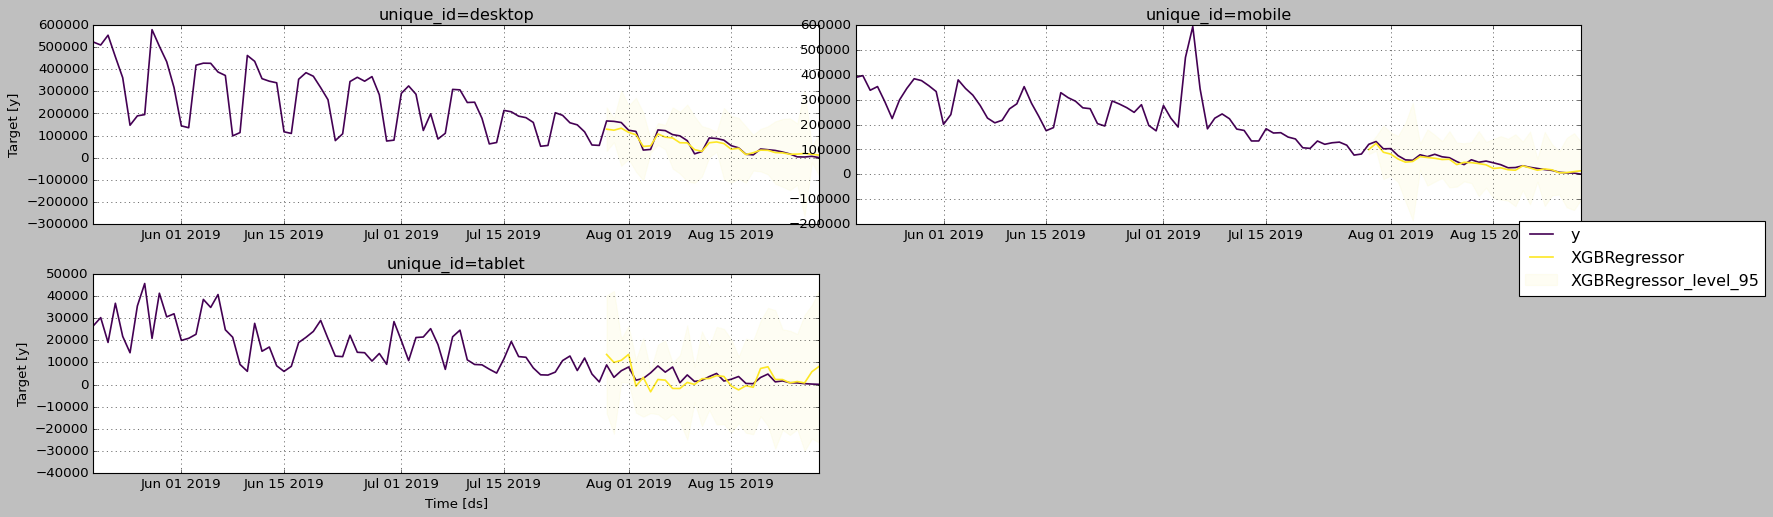

In [157]:
plot_series(data, forecast_best,  max_insample_length=100,  models= ["XGBRegressor"], level= [95])

# **References** <a class="anchor" id="8"></a>

[Table of Contents](#0)


1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters for Mlforecast](https://nixtla.github.io/mlforecast/forecast.html).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).
8. [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)
9. https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py